# Impianto Fotovoltaico Domestico: Produzione, Autoconsumo e Redditività

### Matteo Vale

#### Corso di Data Science, aa. 2024-2025

### **Motivazioni**
* **Interesse personale:** analizzare i dati dell'impianto di casa per comprenderne il comportamento reale.
* **Contesto attuale:** crescente importanza delle energie rinnovabili e volatilità dei costi energetici.
<br><br><br>
### **Domande iniziali:**
1.  Come varia la produzione di energia durante l'anno e quali sono i pattern principali?
2.  In che modo le abitudini di consumo alterano l'efficienza dell'impianto?
3.  Qual è l'impatto economico reale dell'impianto?

## Informazioni sull'Impianto:
* 14 moduli, per una potenza totale di 6,44 KWp
* 3 batterie, per un totale di 14,4 KWh

# Codice

In [1]:
# Aggiunto per correggere slides
from IPython.display import HTML
HTML('''
<style>
.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
    text-transform: none !important;
}
</style>
''')

## Importiamo le librerie necessarie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import plotly.express as px
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import calplot

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Importiamo i Dataset e puliamo dove necessario

In [3]:
df_fotov = pd.read_csv('dati_pannelli.csv', sep=',')
df_fotov['Data'] = pd.to_datetime(df_fotov['Data'])

df_meteo_2023 = pd.read_csv('dati-giornalieri-Gemona del Friuli-202399.csv', sep=';')
df_meteo_2024 = pd.read_csv('dati-giornalieri-Gemona del Friuli-202499.csv', sep=';')
df_meteo_2025 = pd.read_csv('dati-giornalieri-Gemona del Friuli-202599.csv', sep=';')

def pulisci_df_meteo(file_path):
    # Estraggo l'anno, con attenzione al suffisso '99'
    anno = int(file_path.split('-')[-1].replace('.csv', '').replace('99', ''))

    df = pd.read_csv(file_path, sep=';')

    # Uso i nomi del mio dataset
    df = df.rename(columns={'giorno*': 'day', 'mese': 'month'})

    # Aggiunta
    df['year'] = anno
    
    # Creo colonna data. Poi userò solo questa, quindi cancello le singole 3.
    df['Data'] = pd.to_datetime(df[['year', 'month', 'day']])
    df = df.drop(columns=['day', 'month', 'year'])
    
    return df

df_meteo_2023 = pulisci_df_meteo('dati-giornalieri-Gemona del Friuli-202399.csv')
df_meteo_2024 = pulisci_df_meteo('dati-giornalieri-Gemona del Friuli-202499.csv')
df_meteo_2025 = pulisci_df_meteo('dati-giornalieri-Gemona del Friuli-202599.csv')

# Unisco i DataFrame
df_meteo = pd.concat([df_meteo_2023, df_meteo_2024, df_meteo_2025])

print(df_meteo.head())

  Pioggia mm Temp. min °C  Temp. med °C Temp. max °C Umidita' min %  \
0        0.3          7.2           9.2         11.5              -   
1        1.9          8.6           9.3         10.3              -   
2        0.0          4.9           9.2         11.9              -   
3        0.0          3.6           8.4         13.2              -   
4        0.4          5.2           7.5          9.1              -   

  Umidita' med % Umidita' max %  Vento med km/h Vento max km/h Dir. V. max °N  \
0              -              -               4             15            161   
1              -              -               3             10            165   
2              -              -               4             17            352   
3              -              -               7             33             22   
4              -              -               4             22            343   

  Radiaz. KJ/m2 Press. med hPa       Data  
0          1917              - 2023-01-01 

### Merge in un unico dataset

In [4]:
# Normalizzo le date (azzera orario)
df_fotov['Data'] = df_fotov['Data'].dt.normalize()
df_meteo['Data'] = df_meteo['Data'].dt.normalize()

df_completo = pd.merge(df_fotov, df_meteo, on='Data', how='inner')

# Controllo che ci siano tutte le date
prima_data = df_completo['Data'].min()
ultima_data = df_completo['Data'].max()

print(f"La prima data nel DataFrame è: {prima_data.date()}")
print(f"L'ULTIMA data nel DataFrame è: {ultima_data.date()}")
print(f"\nDimensioni del DataFrame unito: {df_completo.shape}")

La prima data nel DataFrame è: 2023-07-20
L'ULTIMA data nel DataFrame è: 2025-07-20

Dimensioni del DataFrame unito: (732, 19)


# Descrizione dei Dataset

* **Dataset Pannelli Fotovoltaici:**
    * **Contenuto:** Produzione, autoconsumo, vendita e acquisto di energia (kWh).
    * **Fonte:** Dati raccolti manualmente, con frequenza giornaliera per 2 anni (dal 20 Luglio 2023 al 20 Luglio 2025).

* **Dataset Meteo:**
    * **Contenuto:** Dati giornalieri di pioggia, temperatura, radiazione solare, umidità.
    * **Fonte:** Archivio storico di <a href="https://www.clima.fvg.it/archivio.php?ln=&p=dati">OSMER FVG</a> per la stazione di Gemona del Friuli.

* **Dataset Economico:**
    * **Contenuto:** Costo e consumo totali per ogni bolletta.
    * **Fonte:** Bollette energetiche di casa (da Maggio 2020 a Giugno 2025).

# Analisi

# 1- Analisi della Produzione Energetica

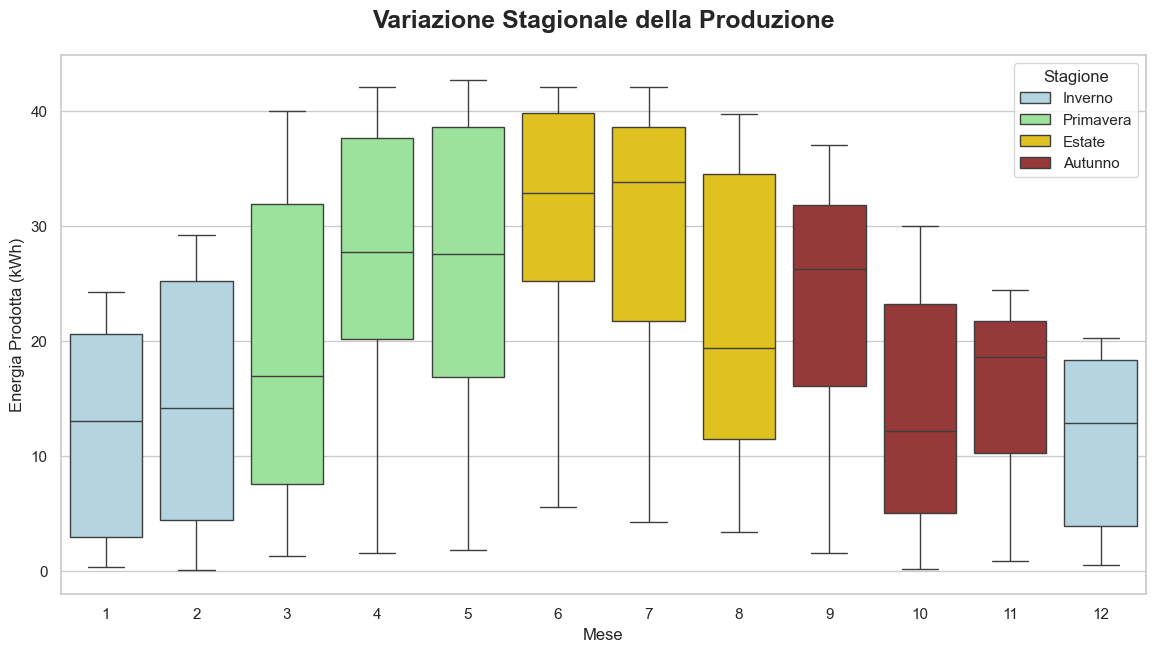

In [5]:
# Creo la colonna 'mese' e grafico boxplot
df_completo['Mese'] = df_completo['Data'].dt.month
def get_stagione(mese):
    if mese in [12, 1, 2]:
        return 'Inverno'
    elif mese in [3, 4, 5]:
        return 'Primavera'
    elif mese in [6, 7, 8]:
        return 'Estate'
    else:
        return 'Autunno'

df_completo['Stagione'] = df_completo['Mese'].apply(get_stagione)

plt.figure(figsize=(14, 7))

sns.boxplot(data=df_completo, x='Mese', y='energia_solare_kwh', hue='Stagione', palette={'Inverno': 'lightblue', 'Primavera': 'lightgreen', 'Estate': 'gold', 'Autunno': 'brown'})

plt.title('Variazione Stagionale della Produzione', fontsize=18, weight='bold', pad=20)
plt.ylabel('Energia Prodotta (kWh)')
plt.xlabel('Mese')

plt.legend(title='Stagione')
plt.show()

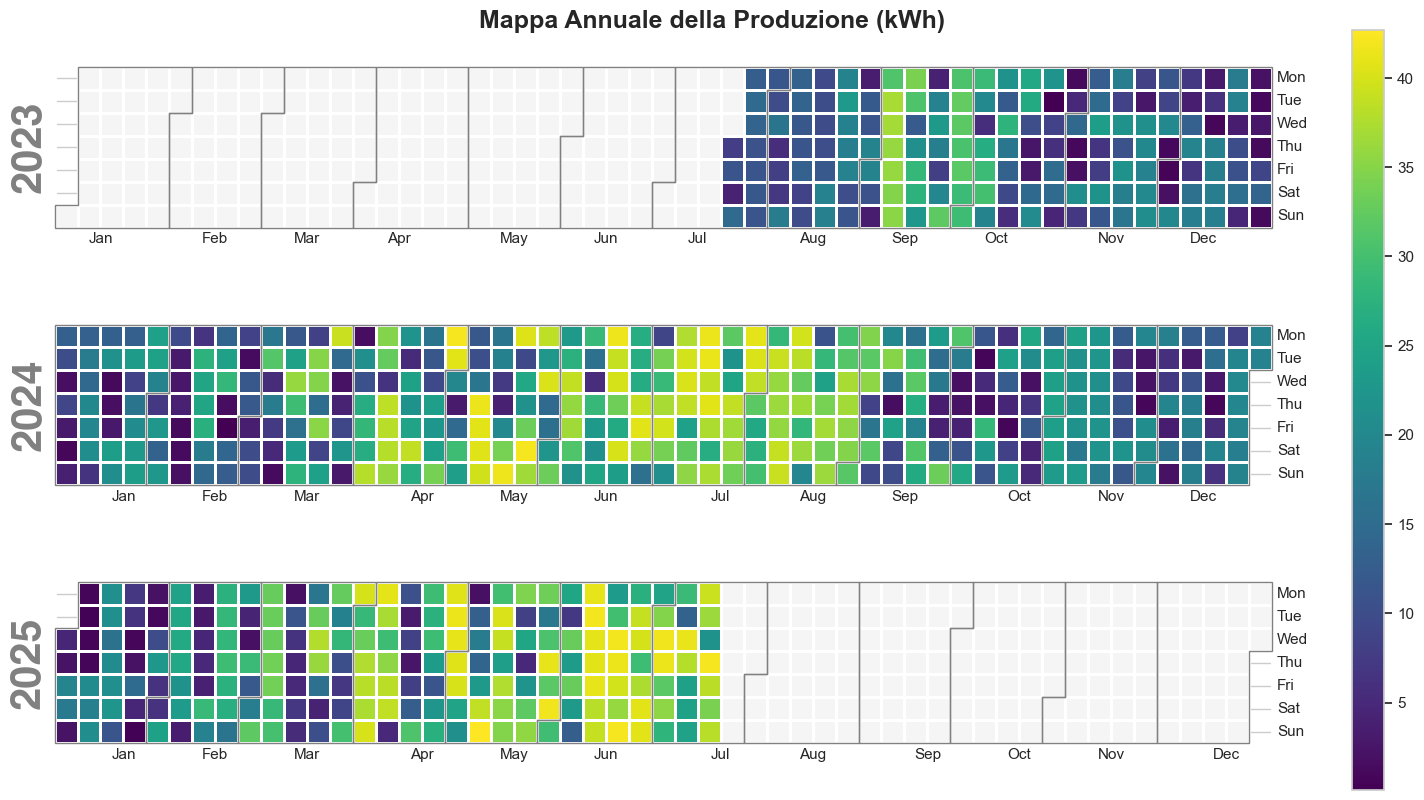

In [6]:
df_calendario = df_completo.set_index('Data')

fig, ax = calplot.calplot(df_calendario['energia_solare_kwh'],
                         cmap='viridis',
                         figsize=(16, 8))

fig.suptitle('Mappa Annuale della Produzione (kWh)',
             fontsize=18,
             weight='bold',
             x=0.45,
             y=1)

plt.show()

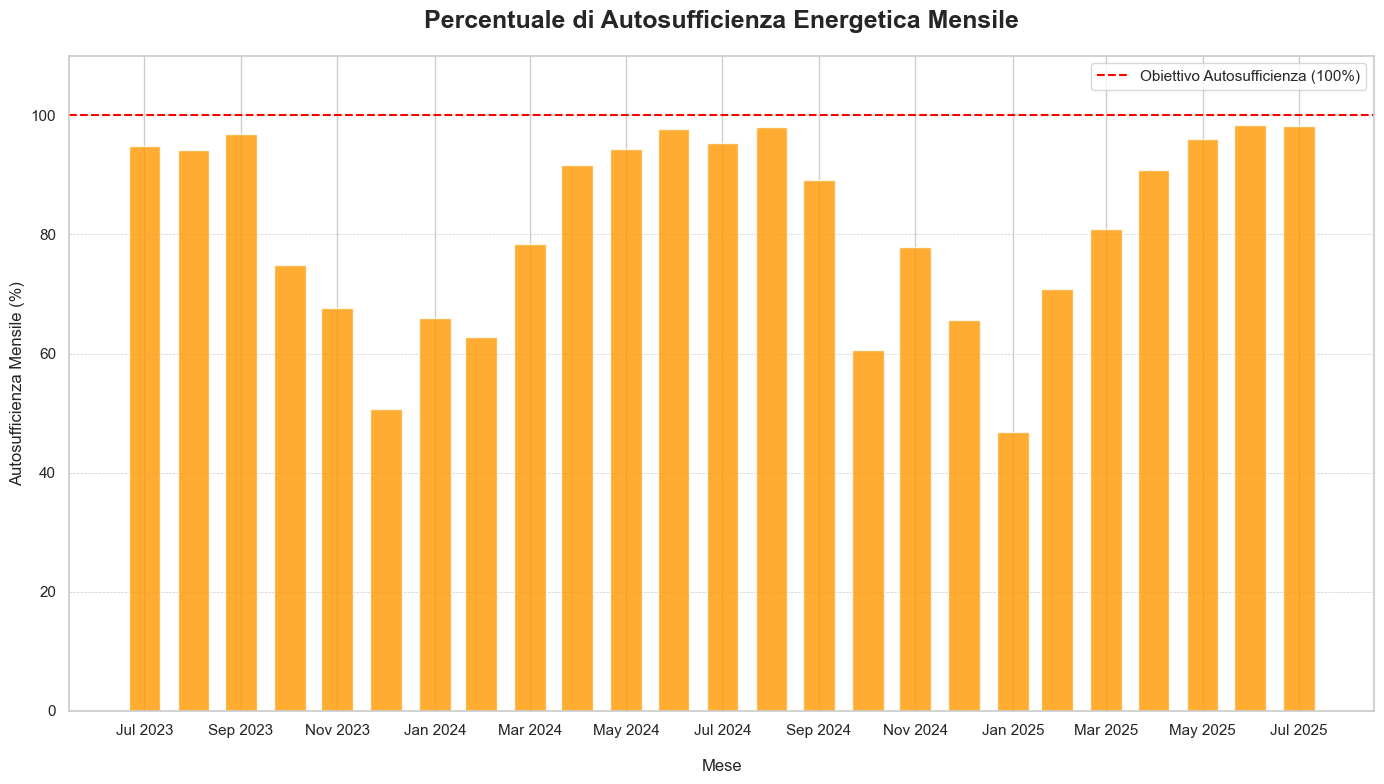

In [7]:
df_fotov['energia_utilizzata_kwh'] = pd.to_numeric(df_fotov['energia_utilizzata_kwh'], errors='coerce')
df_fotov['energia_acquistata_kwh'] = pd.to_numeric(df_fotov['energia_acquistata_kwh'], errors='coerce')
df_fotov = df_fotov.fillna(0)
df_fotov['autoconsumo_kwh'] = df_fotov['energia_utilizzata_kwh'] - df_fotov['energia_acquistata_kwh']
df_mensile_consumi = df_fotov.resample('ME', on='Data')[['energia_utilizzata_kwh', 'energia_acquistata_kwh', 'autoconsumo_kwh']].sum()
df_mensile_consumi['autosufficienza_%'] = (df_mensile_consumi['autoconsumo_kwh'] / df_mensile_consumi['energia_utilizzata_kwh'].replace(0, np.nan)) * 100
df_mensile_consumi.dropna(inplace=True)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))

colori_barre = np.where(df_mensile_consumi['autosufficienza_%'] >= 100, '#4caf50', '#ff9800')

bars = ax.bar(df_mensile_consumi.index, df_mensile_consumi['autosufficienza_%'],
              width=20, color=colori_barre, alpha=0.8)

ax.set_title('Percentuale di Autosufficienza Energetica Mensile', fontsize=18, weight='bold', pad=20)
ax.set_xlabel('Mese', fontsize=12, labelpad=15)
ax.set_ylabel('Autosufficienza Mensile (%)', fontsize=12)
ax.set_ylim(0, 110)
ax.grid(axis='y', linestyle='--', linewidth=0.5)

ax.axhline(y=100, color='red', linestyle='--', linewidth=1.5, label='Obiettivo Autosufficienza (100%)')

# Posizioni ed etichette ogni due mesi
tick_positions = df_mensile_consumi.index[::2]
tick_labels = df_mensile_consumi.index[::2].strftime('%b %Y')

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center')

ax.legend()
plt.tight_layout()
plt.show()

# Approfondimento: l'Impatto della Temperatura sull'Efficienza

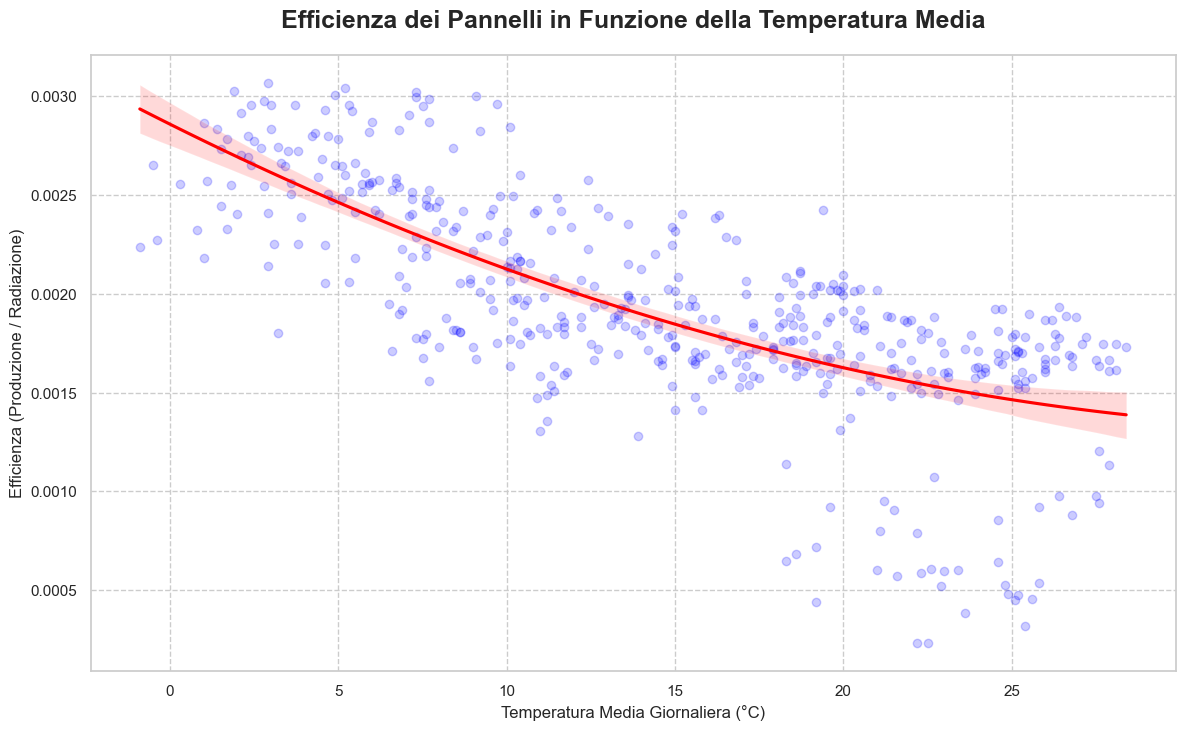

In [8]:
df_completo['Radiaz. KJ/m2'] = df_completo['Radiaz. KJ/m2'].str.replace(',', '.', regex=True)
df_completo['Radiaz. KJ/m2'] = pd.to_numeric(df_completo['Radiaz. KJ/m2'], errors='coerce')
df_completo['energia_solare_kwh'] = pd.to_numeric(df_completo['energia_solare_kwh'], errors='coerce')

# Calcolo colonna efficienza solo dove la radiazione è maggiore di zero.
df_completo['Efficienza'] = 0.0
mask_radiazione_positiva = df_completo['Radiaz. KJ/m2'] > 0
df_completo.loc[mask_radiazione_positiva, 'Efficienza'] = \
    df_completo['energia_solare_kwh'] / df_completo['Radiaz. KJ/m2']

# Considero solo se valori significativi
df_soleggiato = df_completo[df_completo['Radiaz. KJ/m2'] > 5000].copy()

plt.figure(figsize=(14, 8))
sns.regplot(
    data=df_soleggiato,
    x='Temp. med °C',
    y='Efficienza',
    order=2, # La relazione non è proprio lineare
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2, 'color': 'blue'} # Punti più trasparenti per vedere meglio la densità
)
plt.title('Efficienza dei Pannelli in Funzione della Temperatura Media', fontsize=18, weight='bold', pad=20)
plt.ylabel('Efficienza (Produzione / Radiazione)')
plt.xlabel('Temperatura Media Giornaliera (°C)')
plt.grid(True, which='both', linestyle='--')
plt.show()

In [9]:
# Spearman mantiene meglio outlier.
correlazione_spearman = df_soleggiato['Efficienza'].corr(df_soleggiato['Temp. med °C'], method='spearman')
correlazione_kendall = df_soleggiato['Efficienza'].corr(df_soleggiato['Temp. med °C'], method='kendall')
correlazione_pearson = df_soleggiato['Efficienza'].corr(df_soleggiato['Temp. med °C'], method='pearson')

# print(correlazione_spearman)   # -0.7387505868690941

### Coefficiente di correlazione di Spearman: -0.739

# Analisi Bonus: La Pioggia Migliora l'Efficienza dei Pannelli? (non esposta)

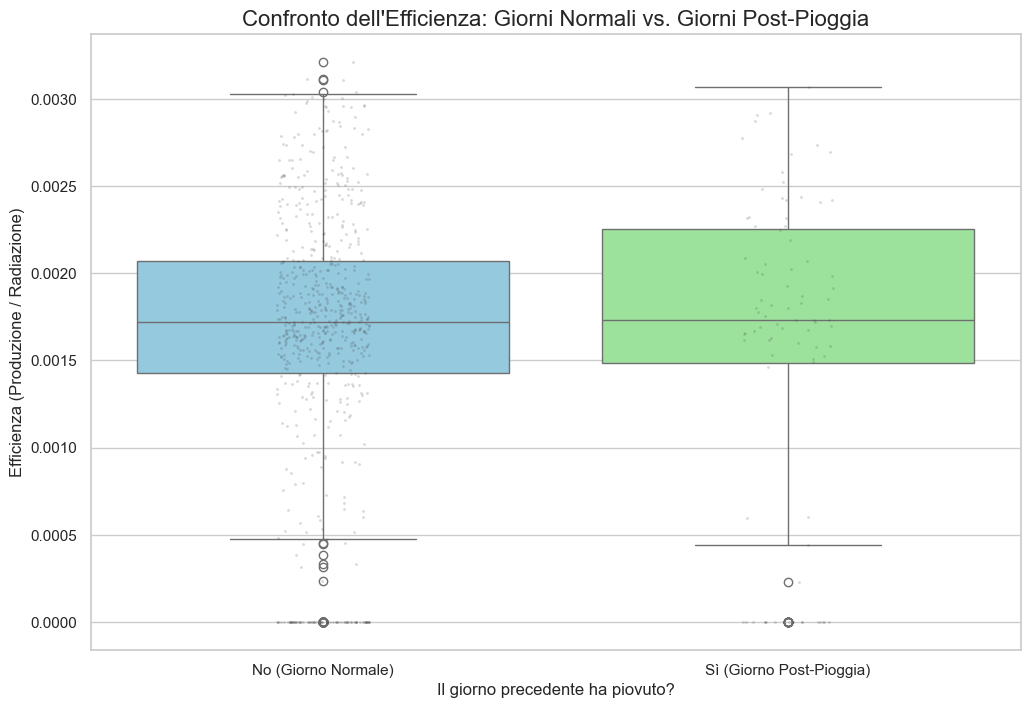

In [10]:
df_completo['Pioggia mm'] = pd.to_numeric(df_completo['Pioggia mm'], errors='coerce')

df_completo['Pioggia_Ieri'] = df_completo['Pioggia mm'].shift(1)
df_completo['Post_Pioggia'] = (df_completo['Pioggia mm'] <= 0.2) & (df_completo['Pioggia_Ieri'] > 1.0)

plt.figure(figsize=(12, 8))
# Uso un boxplot per confrontare le distribuzioni e uno stripplot per vedere i punti
sns.boxplot(data=df_completo, x='Post_Pioggia', y='Efficienza', hue='Post_Pioggia', palette=['skyblue', 'lightgreen'], legend=False)
sns.stripplot(data=df_completo, x='Post_Pioggia', y='Efficienza', color=".25", size=2, alpha=0.2)

plt.title('Confronto dell\'Efficienza: Giorni Normali vs. Giorni Post-Pioggia', fontsize=16)
plt.ylabel('Efficienza (Produzione / Radiazione)')
plt.xlabel('Il giorno precedente ha piovuto?')
plt.xticks([False, True], ['No (Giorno Normale)', 'Sì (Giorno Post-Pioggia)'])
plt.show()

In [11]:
# --- Test di Significatività Statistica (T-Test) ---

# Separo i due campioni
efficienza_post_pioggia = df_completo[df_completo['Post_Pioggia'] == True]['Efficienza']
efficienza_normale = df_completo[df_completo['Post_Pioggia'] == False]['Efficienza']

# L'opzione 'equal_var=False' esegue il test di Welch, più robusto se le varianze sono diverse.
t_stat, p_value = ttest_ind(efficienza_post_pioggia, efficienza_normale, nan_policy='omit', equal_var=False)

print("\n--- Risultati del Test Statistico (T-Test) ---")
print(f"Media Efficienza Giorni Post-Pioggia: {efficienza_post_pioggia.mean():.6f}")
print(f"Media Efficienza Giorni Normali:      {efficienza_normale.mean():.6f}")
print(f"\nStatistica T: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05  # Livello di significatività
if p_value < alpha:
    print("\nConclusione: Il p-value è minore di 0.05. Rifiutiamo l'ipotesi nulla.")
    print("La differenza nell'efficienza tra i due gruppi è statisticamente significativa.")
else:
    print("\nConclusione: Il p-value è maggiore di 0.05. Non possiamo rifiutare l'ipotesi nulla.")
    print("Non c'è una prova statisticamente significativa che la pioggia migliori l'efficienza.")



--- Risultati del Test Statistico (T-Test) ---
Media Efficienza Giorni Post-Pioggia: 0.001573
Media Efficienza Giorni Normali:      0.001640

Statistica T: -0.6465
P-value: 0.5195

Conclusione: Il p-value è maggiore di 0.05. Non possiamo rifiutare l'ipotesi nulla.
Non c'è una prova statisticamente significativa che la pioggia migliori l'efficienza.


## Approfondimento: effetto di una pioggia in un giorno prevalentemente soleggiato

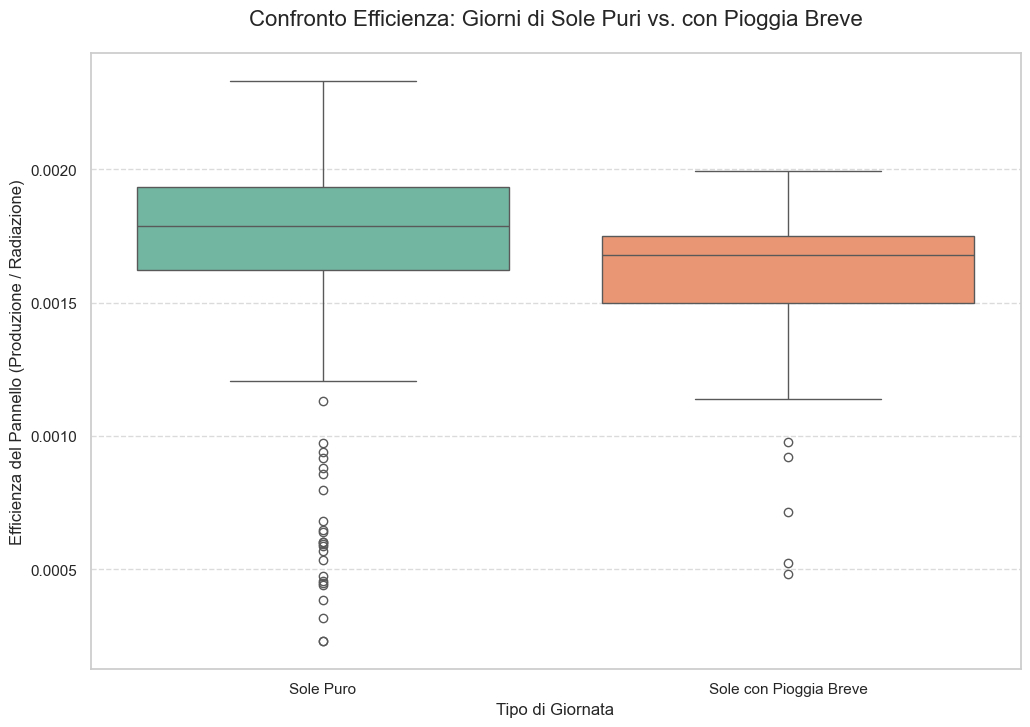


--- Risultati del Test Statistico (T-Test) ---
Media Efficienza 'Sole con Pioggia Breve': 0.001549
Media Efficienza 'Sole Puro':              0.001687

P-value: 0.0454

Conclusione: La differenza è statisticamente significativa.


In [12]:
# Condizioni scelte
RADIAZIONE_SOGLIA = 12000  # Soglia per definire un "giorno di sole"
PIOGGIA_MAX_BREVE = 5      # Soglia massima in mm per una "pioggia breve"
PIOGGIA_MIN = 0.2          # Soglia minima per considerare pioggia

# Funzione per categorizzare i giorni
def categorizza_giornata_soleggiata(row):
    radiazione = row['Radiaz. KJ/m2']
    pioggia = row['Pioggia mm']
    
    if radiazione > RADIAZIONE_SOGLIA:
        if pioggia > PIOGGIA_MIN and pioggia <= PIOGGIA_MAX_BREVE:
            return 'Sole con Pioggia Breve'
        elif pioggia <= PIOGGIA_MIN:
            return 'Sole Puro'
    return 'Altro' # Tutti gli altri giorni (nuvolosi, molto piovosi, ecc.)

df_completo['Tipo_Giornata_Soleggiata'] = df_completo.apply(categorizza_giornata_soleggiata, axis=1)

# Filtro il DataFrame per tenere solo i due gruppi di interesse
df_analisi_pioggia = df_completo[df_completo['Tipo_Giornata_Soleggiata'].isin(['Sole con Pioggia Breve', 'Sole Puro'])]

# Visualizzazione con Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_analisi_pioggia,
    x='Tipo_Giornata_Soleggiata',
    y='Efficienza',
    hue='Tipo_Giornata_Soleggiata',
    palette=['#66c2a5', '#fc8d62'],
    legend=False
)
plt.title('Confronto Efficienza: Giorni di Sole Puri vs. con Pioggia Breve', fontsize=16, pad=20)
plt.xlabel('Tipo di Giornata', fontsize=12)
plt.ylabel('Efficienza del Pannello (Produzione / Radiazione)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Test di Significatività Statistica (T-Test)
efficienza_con_pioggia = df_analisi_pioggia[df_analisi_pioggia['Tipo_Giornata_Soleggiata'] == 'Sole con Pioggia Breve']['Efficienza']
efficienza_senza_pioggia = df_analisi_pioggia[df_analisi_pioggia['Tipo_Giornata_Soleggiata'] == 'Sole Puro']['Efficienza']

# (eseguo solo se dati sufficienti)
if len(efficienza_con_pioggia) > 1 and len(efficienza_senza_pioggia) > 1:
    t_stat, p_value = ttest_ind(efficienza_con_pioggia, efficienza_senza_pioggia, nan_policy='omit', equal_var=False)

    print("\n--- Risultati del Test Statistico (T-Test) ---")
    print(f"Media Efficienza 'Sole con Pioggia Breve': {efficienza_con_pioggia.mean():.6f}")
    print(f"Media Efficienza 'Sole Puro':              {efficienza_senza_pioggia.mean():.6f}")
    print(f"\nP-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusione: La differenza è statisticamente significativa.")
    else:
        print("\nConclusione: La differenza non è statisticamente significativa.")
else:
    print("\nNon ci sono dati sufficienti in una o entrambe le categorie per eseguire un'analisi statistica.")

# 2- Impatto delle Abitudini di Consumo

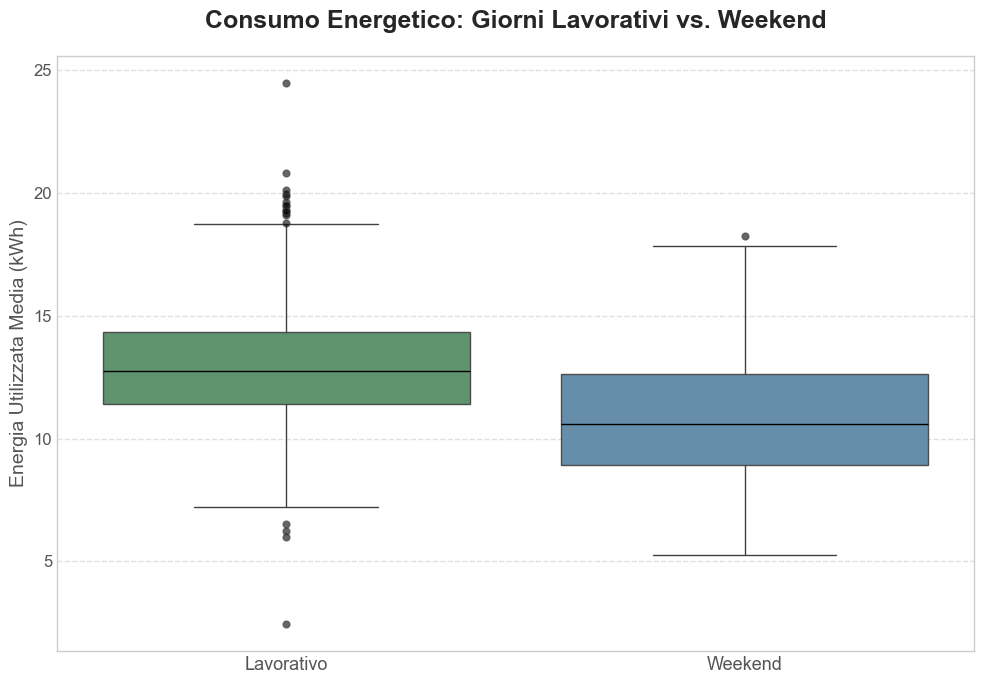

In [13]:
df_completo['giorno_settimana_en'] = df_completo['Data'].dt.day_name()

# Serviva per un altro grafico che ho poi rimosso, mantengo per eventuali modifiche
giorni_traduzione = {
    'Monday': 'Lunedì',
    'Tuesday': 'Martedì',
    'Wednesday': 'Mercoledì',
    'Thursday': 'Giovedì',
    'Friday': 'Venerdì',
    'Saturday': 'Sabato',
    'Sunday': 'Domenica'
}
df_completo['giorno_settimana'] = df_completo['giorno_settimana_en'].map(giorni_traduzione)

# Aggiunto per sistemare ordine
giorni_ordinati = ['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica']
df_completo['giorno_settimana'] = pd.Categorical(df_completo['giorno_settimana'], categories=giorni_ordinati, ordered=True)
df_completo['Tipo Giorno'] = np.where(df_completo['giorno_settimana'].isin(['Sabato', 'Domenica']), 'Weekend', 'Lavorativo')

# Aggiunto per sistemare errori oggetto
colonne_energia = [
    'energia_solare_kwh',
    'energia_utilizzata_kwh',
    'energia_autoprodotta_kwh',
    'energia_venduta_kwh',
    'energia_acquistata_kwh'
]

for col in colonne_energia:
    if df_completo[col].dtype == 'object':
        df_completo[col] = df_completo[col].str.replace(',', '.', regex=True)
    df_completo[col] = pd.to_numeric(df_completo[col], errors='coerce')

# ======== #

df_consumo_settimanale = df_completo.groupby('Tipo Giorno').agg({
    'energia_solare_kwh': 'mean',
    'energia_utilizzata_kwh': 'mean',
    'energia_autoprodotta_kwh': 'mean',
    'energia_venduta_kwh': 'mean',
    'energia_acquistata_kwh': 'mean'
}).reset_index()

# Tasso di Autoconsumo: Quanta dell'energia PRODOTTA viene consumata in casa
df_consumo_settimanale['tasso_autoconsumo_%'] = (df_consumo_settimanale['energia_autoprodotta_kwh'] / df_consumo_settimanale['energia_solare_kwh']) * 100

# Tasso di Autosufficienza: Quanta dell'energia CONSUMATA proviene dal nostro impianto
df_consumo_settimanale['tasso_autosufficienza_%'] = (df_consumo_settimanale['energia_autoprodotta_kwh'] / df_consumo_settimanale['energia_utilizzata_kwh']) * 100

colori_tipo_giorno = {
    'Lavorativo': '#44935B',
    'Weekend': '#4884AF'
}

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Boxplot
sns.boxplot(
    data=df_completo,
    x='Tipo Giorno',
    y='energia_utilizzata_kwh',
    ax=ax,
    palette=colori_tipo_giorno, #Verde=lavorativo, blu=weekend
    hue='Tipo Giorno',
    legend=False,
    linewidth=1,
    width=0.8,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=5, linestyle='none', alpha=0.6),
    boxprops=dict(alpha=0.9),
    medianprops=dict(color='black', linewidth=1)
)

ax.set_title('Consumo Energetico: Giorni Lavorativi vs. Weekend',
             fontsize=18, weight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Energia Utilizzata Media (kWh)', fontsize=14, color='#555555')

ax.tick_params(axis='x', labelsize=13, colors='#555555')
ax.tick_params(axis='y', labelsize=12, colors='#555555')

ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

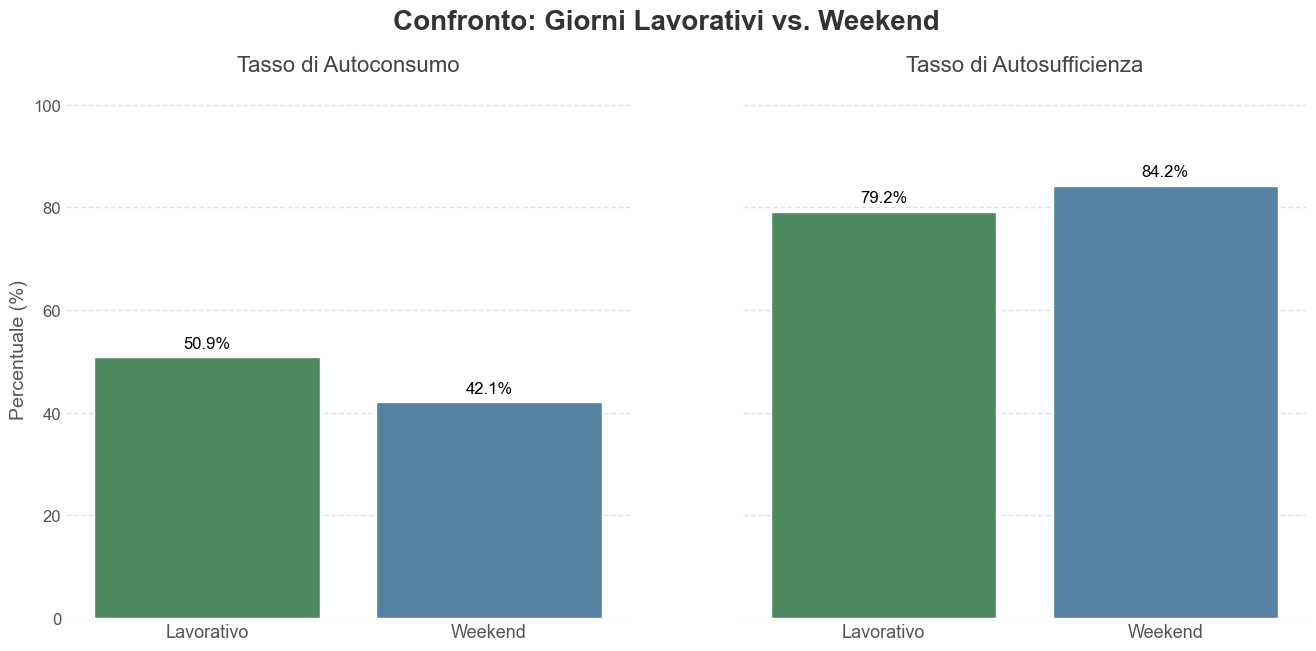

In [14]:
# Palette più chiara
'''
colori_pastello = {
    'Lavorativo': '#B3D7AE',
    'Weekend': '#B3CEDE'
}
'''

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Confronto: Giorni Lavorativi vs. Weekend', fontsize=20, weight='bold', color='#333333')

# Grafico Autoconsumo
sns.barplot(
    data=df_consumo_settimanale,
    x='Tipo Giorno',
    y='tasso_autoconsumo_%',
    ax=axes[0],
    palette=colori_tipo_giorno,
    hue='Tipo Giorno',
    legend=False
)
axes[0].set_title('Tasso di Autoconsumo', fontsize=16, color='#444444')
axes[0].set_ylabel('Percentuale (%)', fontsize=14, color='#555555')
axes[0].set_xlabel('')
axes[0].set_ylim(0, 105)

# Grafico Autosufficienza
sns.barplot(
    data=df_consumo_settimanale,
    x='Tipo Giorno',
    y='tasso_autosufficienza_%',
    ax=axes[1],
    palette=colori_tipo_giorno,
    hue='Tipo Giorno',
    legend=False
)
axes[1].set_title('Tasso di Autosufficienza', fontsize=16, color='#444444')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

for ax in axes:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')
    ax.tick_params(axis='x', labelsize=13, colors='#555555')
    ax.tick_params(axis='y', labelsize=12, colors='#555555')
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.grid(False)

sns.despine(left=True, bottom=True)
fig.subplots_adjust(wspace=0.2)
plt.show()

# 3- Analisi Economica

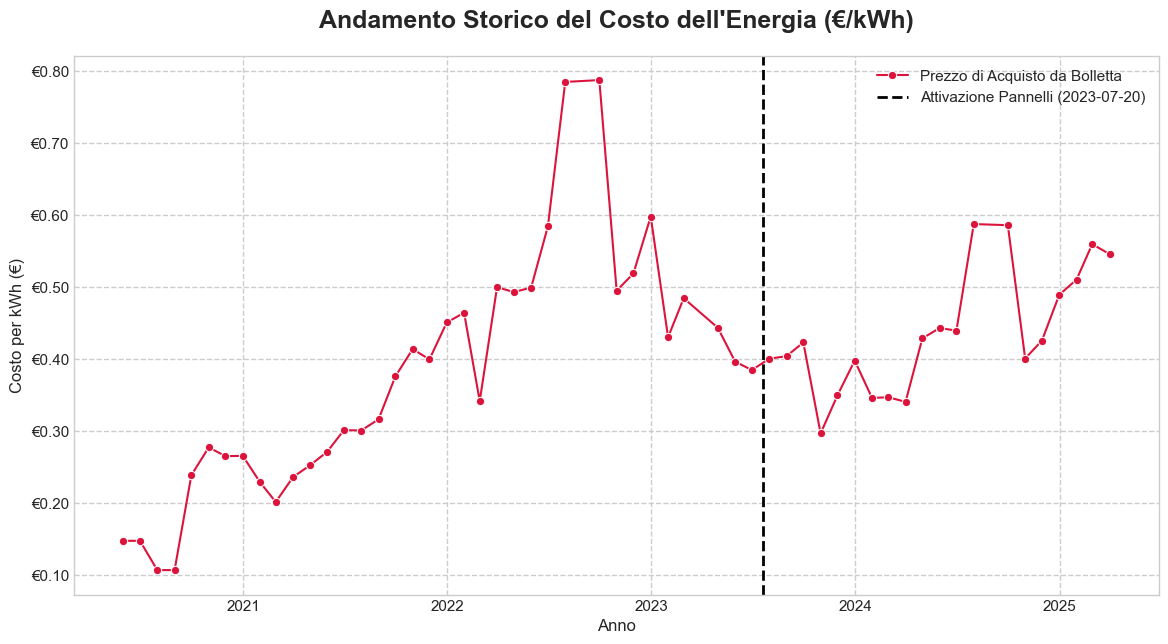

In [15]:
try:
    df_bollette = pd.read_csv('bollette.csv')

    # Formato data in ita
    import locale
    try:
        locale.setlocale(locale.LC_TIME, 'it_IT.UTF-8')
    except locale.Error:
        locale.setlocale(locale.LC_TIME, 'Italian_Italy.1252')

    
    df_bollette['Data'] = pd.to_datetime(df_bollette['anno'].astype(str) + '-' + df_bollette['mese'].astype(str), format='%Y-%B') + pd.offsets.MonthEnd(0)
    locale.setlocale(locale.LC_TIME, '')

    df_bollette['prezzo_kwh_acquisto'] = df_bollette['costo'] / df_bollette['consumi']
    data_attivazione_pannelli = pd.to_datetime('2023-07-20')

    # Rimuovo outlier (metodo IQR). Altrimenti poco leggibile
    Q1 = df_bollette['prezzo_kwh_acquisto'].quantile(0.25)
    Q3 = df_bollette['prezzo_kwh_acquisto'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_bollette_filtered = df_bollette[(df_bollette['prezzo_kwh_acquisto'] >= lower_bound) & (df_bollette['prezzo_kwh_acquisto'] <= upper_bound)]

    # Grafico: Andamento del costo dell'energia
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_bollette_filtered, x='Data', y='prezzo_kwh_acquisto', marker='o', color='crimson', label='Prezzo di Acquisto da Bolletta')
    
    # Linea verticale per indicare l'attivazione dei pannelli
    plt.axvline(x=data_attivazione_pannelli, color='black', linestyle='--', linewidth=2, label=f'Attivazione Pannelli ({data_attivazione_pannelli.date()})')
    
    plt.title("Andamento Storico del Costo dell'Energia (€/kWh)", fontsize=18, weight='bold', pad=20)
    plt.ylabel("Costo per kWh (€)")
    plt.xlabel("Anno")
    plt.grid(True, which='both', linestyle='--')
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('€%.2f'))
    plt.legend()
    plt.show()

except FileNotFoundError:
    print("errore file")
    df_bollette = pd.DataFrame()

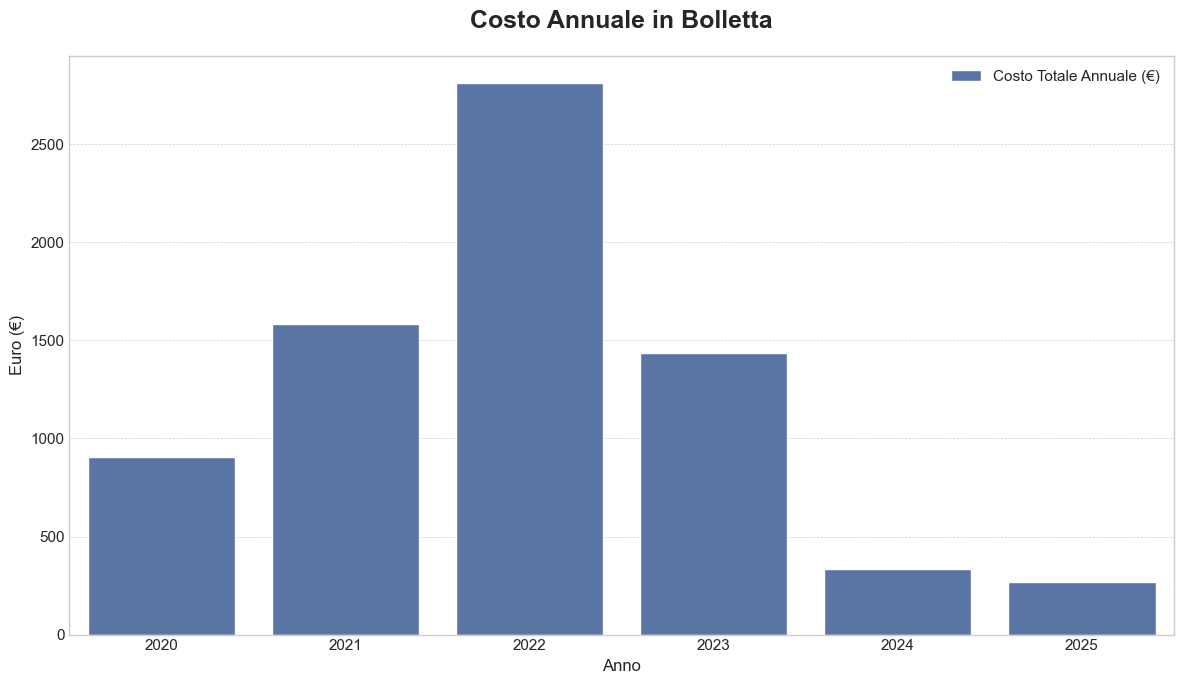

In [16]:
# Somma dei costi raggruppata per anno
df_annuale = df_bollette.groupby(df_bollette['Data'].dt.year).agg({'costo': 'sum'}).reset_index()

df_annuale.rename(columns={'Data': 'Anno'}, inplace=True)

data_installazione = pd.to_datetime('2023-07-20')

sns.set_theme(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=df_annuale, x='Anno', y='costo', color='b', ax=ax, label='Costo Totale Annuale (€)')

ax.set_title("Costo Annuale in Bolletta", fontsize=18, weight='bold', pad=20)
ax.set_xlabel('Anno', fontsize=12)
ax.set_ylabel('Euro (€)', fontsize=12)
ax.legend()
ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [17]:
# Calcolo €/kwh di vendita al fornitore (importo preso da bonifico)
start_date = '2024-12-01'
end_date = '2025-06-30'
importo_pagato = 65.59

df_periodo = df_fotov[(df_fotov['Data'] >= start_date) & (df_fotov['Data'] <= end_date)]
energia_venduta_totale = df_periodo['energia_venduta_kwh'].sum()

prezzo_vendita_kwh = importo_pagato / energia_venduta_totale
print(f"€{prezzo_vendita_kwh:.4f} per kWh venduto.")

€0.0400 per kWh venduto.


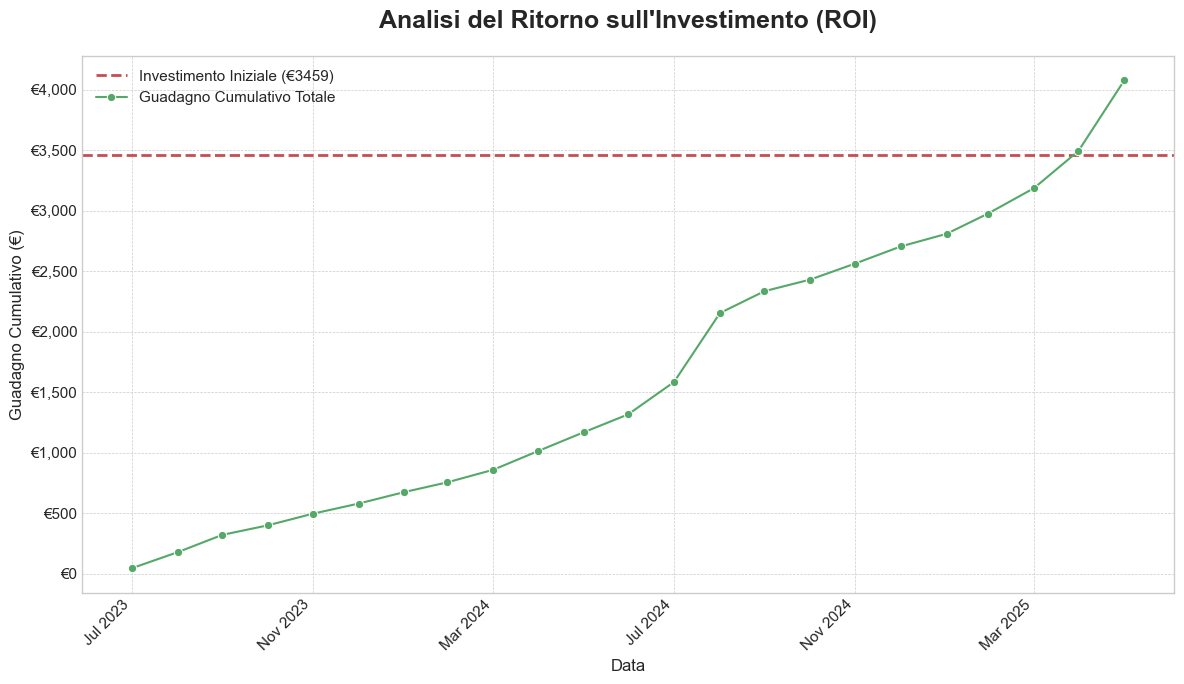

In [18]:
df_fotov_mensile = df_completo.set_index('Data').resample('ME').sum(numeric_only=True).reset_index()
df_bollette_prezzi_mensile = df_bollette.set_index('Data').resample('ME').mean(numeric_only=True).reset_index()
df_analisi_economica = pd.merge(df_fotov_mensile, df_bollette_prezzi_mensile, on='Data', how='inner')

df_analisi_economica['risparmio_autoconsumo'] = df_analisi_economica['energia_autoprodotta_kwh'] * df_analisi_economica['prezzo_kwh_acquisto']
df_analisi_economica.dropna(subset=['risparmio_autoconsumo'], inplace=True)

# prezzo_vendita_kwh = 0.04   (calcolato sopra)
investimento_iniziale = 3459

df_post_installazione = df_analisi_economica[df_analisi_economica['Data'] >= data_attivazione_pannelli].copy()

df_post_installazione['guadagno_vendita'] = df_post_installazione['energia_venduta_kwh'] * prezzo_vendita_kwh
df_post_installazione['guadagno_totale_mensile'] = df_post_installazione['risparmio_autoconsumo'] + df_post_installazione['guadagno_vendita']    
df_post_installazione['guadagno_cumulativo'] = df_post_installazione['guadagno_totale_mensile'].cumsum()

plt.figure(figsize=(12, 7))
ax = plt.gca()

# Investimento iniziale
ax.axhline(y=investimento_iniziale, color='r', linestyle='--', linewidth=2, label=f'Investimento Iniziale (€{investimento_iniziale})')

# Guadagno cumulativo
sns.lineplot(data=df_post_installazione, x='Data', y='guadagno_cumulativo', marker='o', linestyle='-', color='g', label='Guadagno Cumulativo Totale', ax=ax)

all_dates = df_post_installazione['Data']
tick_locations = all_dates[::4] 
ax.xaxis.set_ticks(tick_locations)

ax.set_title("Analisi del Ritorno sull'Investimento (ROI)", fontsize=18, weight='bold', pad=20)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Guadagno Cumulativo (€)', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{int(x):,}'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Conclusioni: Sintesi dei Risultati

### **Risposta 1: Stagionalità**
La produzione fotovoltaica è fortemente stagionale. L'analisi ci permette di prevedere i periodi di massima e minima generazione.

Inoltre, l'efficienza è inversamente correlata alla temperatura.
### **Risposta 2: In Sintesi**
Sebbene la produzione sia simile, nei giorni lavorativi si registra un tasso di autoconsumo più elevato, massimizzando il valore dell'energia prodotta. 

Nei weekend, al contrario, si ottiene un'autosufficienza maggiore, ma con un minore tasso di autoconsumo a causa dell'energia in eccesso che viene rivenduta.
### **Risposta 3: Impatto Economico**
L'impianto installato ha superato il punto di pareggio finanziario, portando un ritorno economico positivo. L'investimento iniziale non solo è stato ripagato, ma il sistema sta ora generando un guadagno continuo grazie all'autoconsumo e alla vendita dell'energia in eccesso.

# Grazie per l'attenzione.